# Challengers Final Project

## Import Statements

In [1]:
import pandas as pd          
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense

## Load in Data

In [2]:
df = pd.concat(map(pd.read_csv, ['tennis_atp/atp_matches_2018.csv','tennis_atp/atp_matches_2019.csv', 'tennis_atp/atp_matches_2020.csv','tennis_atp/atp_matches_2021.csv','tennis_atp/atp_matches_2022.csv','tennis_atp/atp_matches_2023.csv','tennis_atp/atp_matches_2024.csv']))

In [3]:
# Remove identifying data
# Find a way to include tourney_level and score
df = df.drop(columns=['winner_id', 'winner_name', 'winner_ioc', 
                      'loser_id', 'loser_name', 'loser_ioc', 
                      'tourney_id', 'tourney_name', 'tourney_level', 
                      'tourney_date', 'match_num', 'winner_seed', 
                      'winner_entry', 'loser_seed', 'loser_entry','score', 'draw_size', 'best_of', 'round', "w_SvGms", "l_SvGms", "w_bpSaved", 
                      "l_bpSaved", "w_bpFaced", "l_bpFaced","minutes"])


## Drop Nulls and Duplicates

In [4]:
# Check for missing values.
print(df.isnull().sum())

# There are zero duplicates no action needed
print(df.duplicated().sum())

# Drop any rows with nulls in them
df = df.dropna()

# Check total number of rows, should be over 15k
row_count = len(df)
print(row_count)

surface                53
winner_hand             0
winner_ht              79
winner_age              3
loser_hand              1
loser_ht              227
loser_age               3
w_ace                 694
w_df                  694
w_svpt                694
w_1stIn               694
w_1stWon              694
w_2ndWon              694
l_ace                 694
l_df                  694
l_svpt                694
l_1stIn               694
l_1stWon              694
l_2ndWon              694
winner_rank            79
winner_rank_points     79
loser_rank            222
loser_rank_points     222
dtype: int64
2
17946


## Convert Categorical Variables to Numerical

In [5]:
winner_hand_encoder = LabelEncoder()
loser_encoder = LabelEncoder()
surface_encoder = LabelEncoder()

df['winner_hand'] = winner_hand_encoder.fit_transform(df['winner_hand'])
df['loser_hand'] = loser_encoder.fit_transform(df['loser_hand'])
df['surface'] = surface_encoder.fit_transform(df['surface'])

## Rename Columns, Create Target, and Balance Classes

In [6]:
# Rename values to not be associated with winner.
df = df.rename(columns={
    'winner_age': 'p1_age',
    'winner_ht': 'p1_ht',
    'winner_hand': 'p1_hand',
    'winner_rank': 'p1_rank',
    'winner_rank_points': 'p1_rank_points',
    'loser_age': 'p2_age',
    'loser_ht': 'p2_ht',
    'loser_hand': 'p2_hand',
    'loser_rank': 'p2_rank',
    'loser_rank_points': 'p2_rank_points',
    
    'w_ace': 'p1_ace',
    'w_df': 'p1_df',
    'w_svpt': 'p1_svpt',
    'w_1stIn': 'p1_1stIn',
    'w_1stWon': 'p1_1stWon',
    'w_2ndWon': 'p1_2ndWon',

    'l_ace': 'p2_ace',
    'l_df': 'p2_df',
    'l_svpt': 'p2_svpt',
    'l_1stIn': 'p2_1stIn',
    'l_1stWon': 'p2_1stWon',
    'l_2ndWon': 'p2_2ndWon',
})

swap_mask = np.random.rand(len(df)) > 0.5

swap_cols = [
    'age', 'ht', 'hand', 'rank', 'rank_points',
    'ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon'
]

for col in swap_cols:
    temp = df.loc[swap_mask, f'p1_{col}'].copy()
    df.loc[swap_mask, f'p1_{col}'] = df.loc[swap_mask, f'p2_{col}']
    df.loc[swap_mask, f'p2_{col}'] = temp

df['winner'] = np.where(swap_mask, 1, 0)

print(df['winner'].value_counts())

winner
0    8995
1    8951
Name: count, dtype: int64


In [7]:
# Display the first and last few rows of the dataset.
display(df.head())
display(df.tail())

# Display the info of the dataset.
display(df.info())

# Display summary statistics of the dataset.
display(df.describe())

,surface,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,p1_ace,p1_df,p1_svpt,...,p2_df,p2_svpt,p2_1stIn,p2_1stWon,p2_2ndWon,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
0,2,1,185.0,25.6,1,188.0,30.6,9.0,2.0,82.0,...,3.0,80.0,47.0,33.0,19.0,47.0,1010.0,52.0,909.0,0
1,2,1,188.0,21.2,1,183.0,23.7,5.0,3.0,58.0,...,5.0,62.0,41.0,25.0,7.0,54.0,890.0,94.0,593.0,0
2,2,1,175.0,25.6,1,185.0,31.3,8.0,6.0,120.0,...,0.0,94.0,66.0,48.0,12.0,30.0,1391.0,63.0,809.0,1
3,2,1,183.0,18.8,1,188.0,28.0,9.0,3.0,66.0,...,2.0,80.0,43.0,33.0,17.0,208.0,245.0,44.0,1055.0,0
4,2,1,188.0,19.9,0,193.0,27.2,5.0,4.0,55.0,...,0.0,45.0,35.0,28.0,5.0,175.0,299.0,68.0,755.0,0


,surface,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,p1_ace,p1_df,p1_svpt,...,p2_df,p2_svpt,p2_1stIn,p2_1stWon,p2_2ndWon,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
3064,2,1,183.0,28.2,1,175.0,25.0,2.0,1.0,50.0,...,2.0,52.0,32.0,25.0,11.0,819.0,24.0,569.0,64.0,1
3066,2,1,178.0,31.0,1,188.0,28.8,4.0,2.0,56.0,...,2.0,49.0,30.0,17.0,9.0,279.0,205.0,900.0,18.0,0
3068,0,0,185.0,23.9,1,188.0,21.8,1.0,2.0,74.0,...,5.0,92.0,52.0,24.0,18.0,616.0,55.0,740.0,34.0,0
3070,0,0,185.0,23.9,1,175.0,34.2,1.0,1.0,82.0,...,1.0,50.0,30.0,19.0,14.0,616.0,55.0,136.0,489.0,1
3074,2,1,185.0,27.3,1,175.0,26.9,5.0,3.0,86.0,...,1.0,84.0,61.0,41.0,13.0,416.0,109.0,554.0,67.0,1


<class 'pandas.core.frame.DataFrame'>
Index: 17946 entries, 0 to 3074
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   surface         17946 non-null  int64  
 1   p1_hand         17946 non-null  int64  
 2   p1_ht           17946 non-null  float64
 3   p1_age          17946 non-null  float64
 4   p2_hand         17946 non-null  int64  
 5   p2_ht           17946 non-null  float64
 6   p2_age          17946 non-null  float64
 7   p1_ace          17946 non-null  float64
 8   p1_df           17946 non-null  float64
 9   p1_svpt         17946 non-null  float64
 10  p1_1stIn        17946 non-null  float64
 11  p1_1stWon       17946 non-null  float64
 12  p1_2ndWon       17946 non-null  float64
 13  p2_ace          17946 non-null  float64
 14  p2_df           17946 non-null  float64
 15  p2_svpt         17946 non-null  float64
 16  p2_1stIn        17946 non-null  float64
 17  p2_1stWon       17946 non-null  float

None

,surface,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,p1_ace,p1_df,p1_svpt,...,p2_df,p2_svpt,p2_1stIn,p2_1stWon,p2_2ndWon,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
count,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.00000,...,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000,17946.000000
mean,1.285468,0.863145,187.274490,27.133534,0.859523,187.185222,27.128168,6.398083,2.926223,81.01967,...,2.940432,81.073554,50.444779,36.085256,15.523515,79.172685,1546.491196,79.453917,1526.961607,0.498774
std,0.901457,0.343704,7.021052,4.553333,0.347491,7.151313,4.590054,5.528145,2.436377,29.21903,...,2.450847,29.212725,19.238541,14.254565,6.849391,109.508962,1747.390127,106.104915,1720.409944,0.500012
min,0.000000,0.000000,71.000000,16.400000,0.000000,15.000000,16.500000,0.000000,0.000000,3.00000,...,0.000000,5.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,1.000000,183.000000,23.700000,1.000000,183.000000,23.600000,3.000000,1.000000,59.00000,...,1.000000,59.000000,36.000000,26.000000,11.000000,25.000000,650.000000,26.000000,640.000000,0.000000
50%,2.000000,1.000000,188.000000,26.800000,1.000000,188.000000,26.700000,5.000000,2.000000,76.00000,...,2.000000,76.000000,47.000000,34.000000,15.000000,55.000000,955.000000,55.000000,946.000000,0.000000
75%,2.000000,1.000000,193.000000,30.200000,1.000000,193.000000,30.300000,9.000000,4.000000,97.00000,...,4.000000,97.000000,61.000000,44.000000,19.000000,94.000000,1650.000000,94.000000,1635.000000,1.000000
max,2.000000,1.000000,211.000000,42.300000,1.000000,211.000000,42.500000,67.000000,25.000000,291.00000,...,26.000000,278.000000,198.000000,166.000000,56.000000,2146.000000,12355.000000,1821.000000,12415.000000,1.000000


In [8]:
# Check for missing values.
print(df.isnull().sum())

surface           0
p1_hand           0
p1_ht             0
p1_age            0
p2_hand           0
p2_ht             0
p2_age            0
p1_ace            0
p1_df             0
p1_svpt           0
p1_1stIn          0
p1_1stWon         0
p1_2ndWon         0
p2_ace            0
p2_df             0
p2_svpt           0
p2_1stIn          0
p2_1stWon         0
p2_2ndWon         0
p1_rank           0
p1_rank_points    0
p2_rank           0
p2_rank_points    0
winner            0
dtype: int64


## Check Number of Rows

In [9]:
# Check row count
row_count = len(df)
print(row_count)

17946


## Scale Features

In [10]:
scaler = StandardScaler()
y = df['winner'].values

X = df.drop(columns=['winner'])
scaler = StandardScaler()
X = scaler.fit_transform(X)

display(y)
display(X)

array([0, 0, 1, ..., 0, 1, 1])

array([[ 0.79266389,  0.39818828, -0.32396192, ..., -0.30703283,
        -0.25875034, -0.3592044 ],
       [ 0.79266389,  0.39818828,  0.10333638, ..., -0.37570859,
         0.13709533, -0.54288667],
       [ 0.79266389,  0.39818828, -1.74828958, ..., -0.0889873 ,
        -0.15507647, -0.4173317 ],
       ...,
       [-1.42602849, -2.51137477, -0.32396192, ..., -0.85357742,
         6.22557861, -0.86781828],
       [-1.42602849, -2.51137477, -0.32396192, ..., -0.85357742,
         0.53294099, -0.60333906],
       [ 0.79266389,  0.39818828, -0.32396192, ..., -0.82267333,
         4.47254782, -0.84863627]])

## Split data into testing and training

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
display(y_train)

array([0, 1, 0, ..., 1, 0, 0])

## Visualizing the results

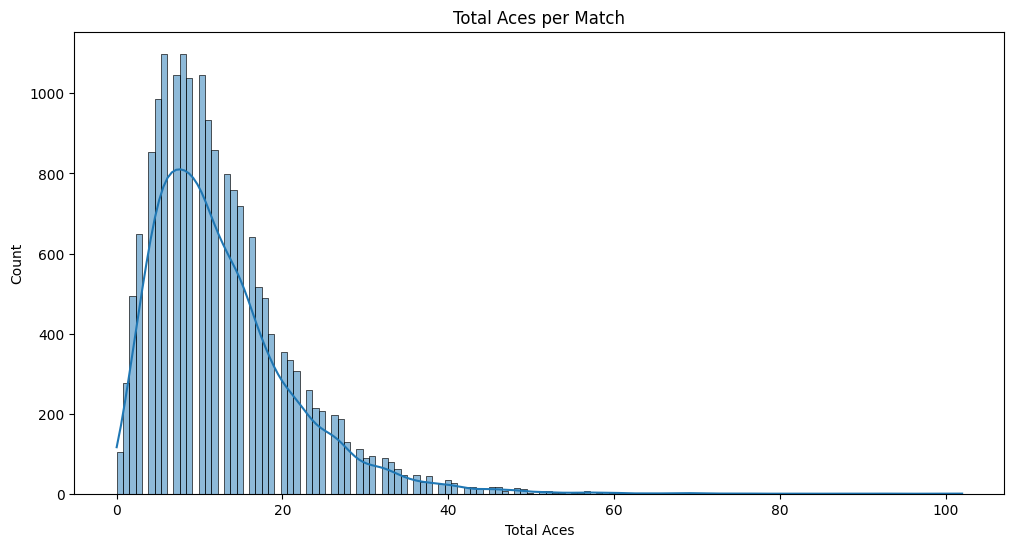

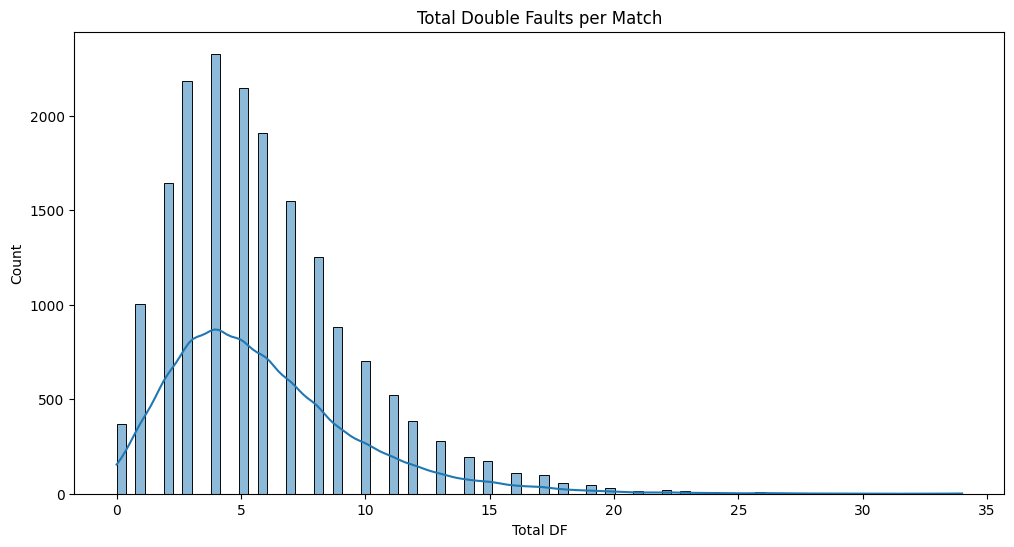

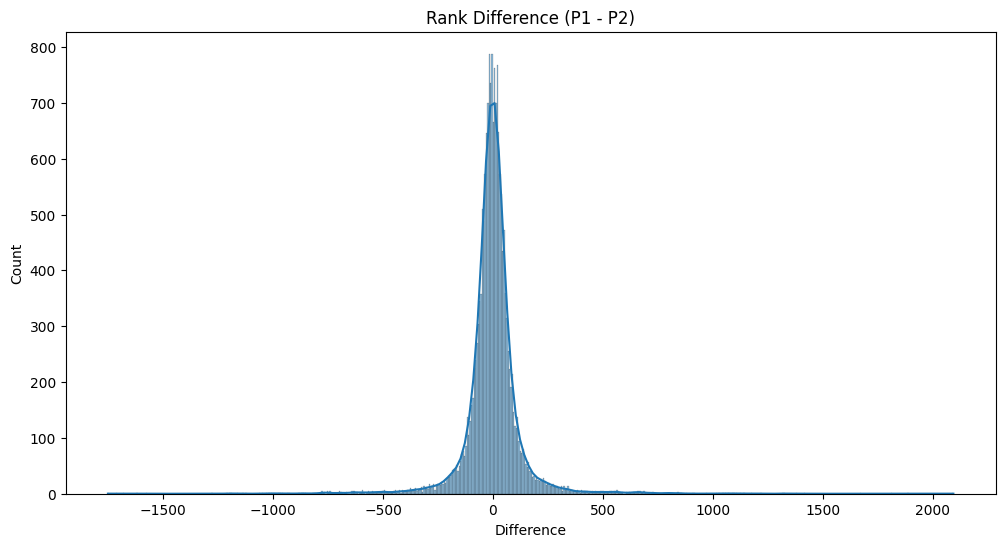

In [12]:
#visualizing the dataset under 4 main categories covering 20 plots
#match overview, serving stats, player attributes, and outcome insights
#these 4 are the general basis but the plots after the first 20 cover more stuff and other variables too
#----------match overview----------
plt.rcParams["figure.figsize"] = (12, 6)

#plot 2: Total Aces Per Match
#displays the service dominance!!!
#a high total may suggest an aggressive play style due to high aces
sns.histplot(df['p1_ace'] + df['p2_ace'], kde=True)
plt.title("Total Aces per Match")
plt.xlabel("Total Aces")
plt.show()

#plot 3: Double Faults Per Match
#reveals how often that the players lose points because of their poor serves
#these double faults can correlate with nerves / poor second serve
sns.histplot(df['p1_df'] + df['p2_df'], kde=True)
plt.title("Total Double Faults per Match")
plt.xlabel("Total DF")
plt.show()

#plot 4: Rank Difference
#this rank difference shows how big of a MISMATCH there is
#a large positive or negative can predict ONE-SIDED matches
df['rank_diff'] = df['p1_rank'] - df['p2_rank']
sns.histplot(df['rank_diff'], kde=True)
plt.title("Rank Difference (P1 - P2)")
plt.xlabel("Difference")
plt.show()

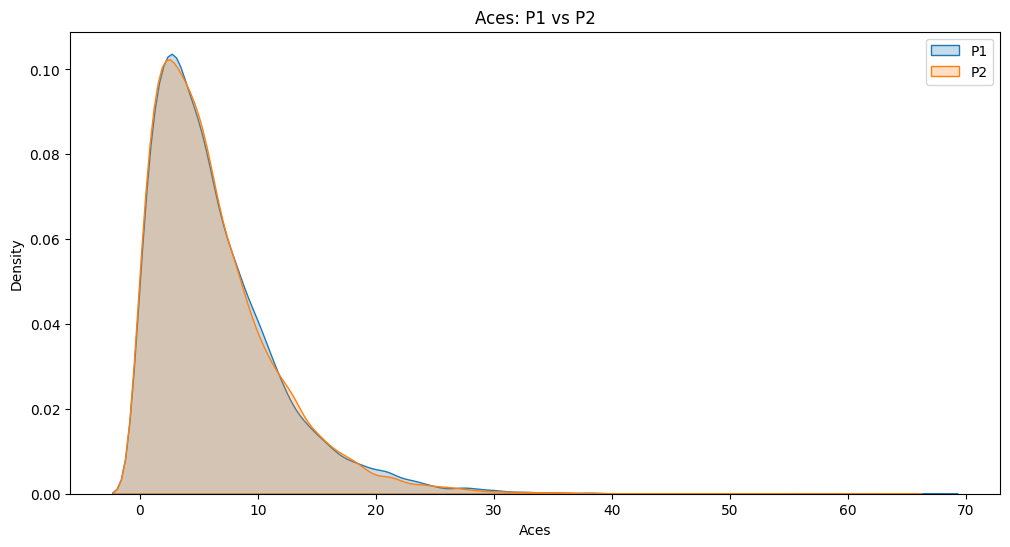

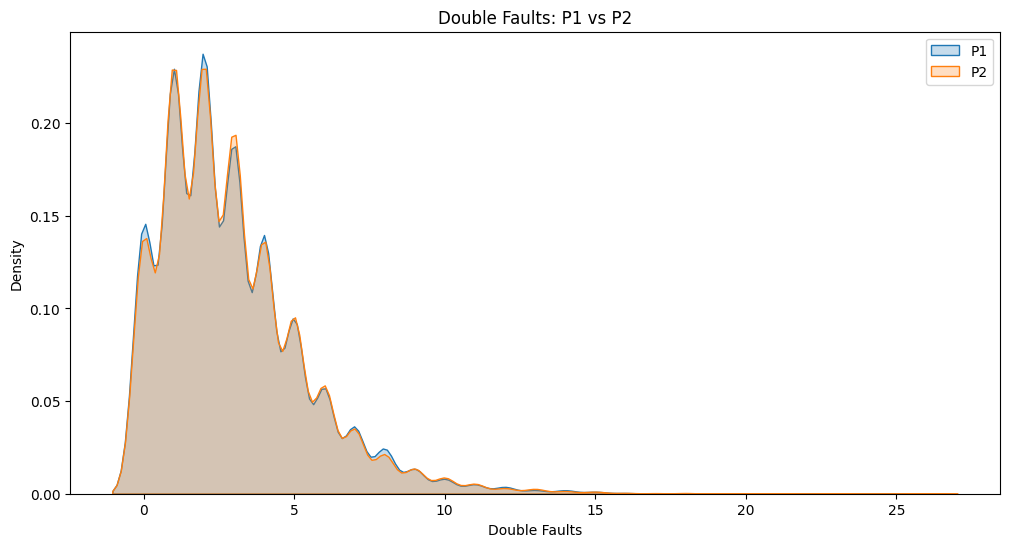

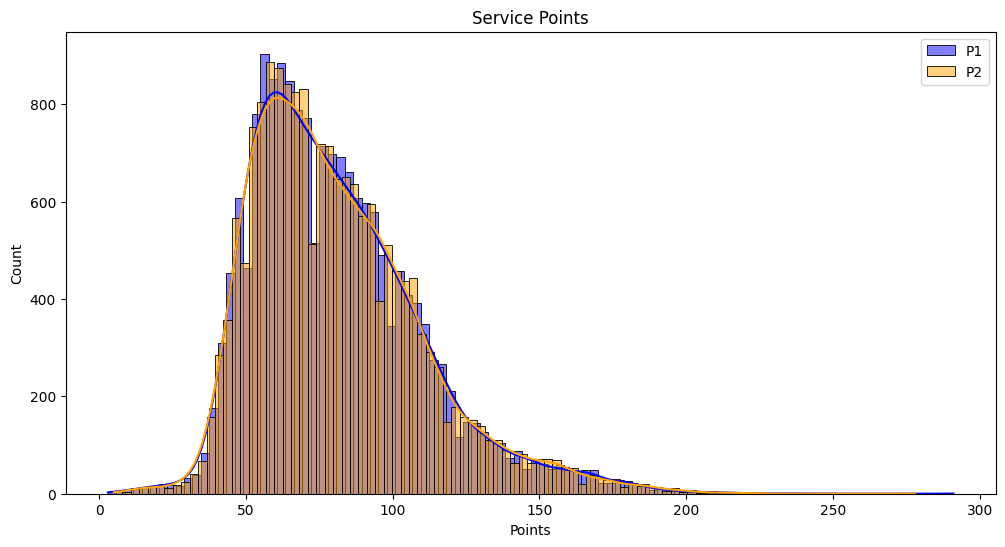

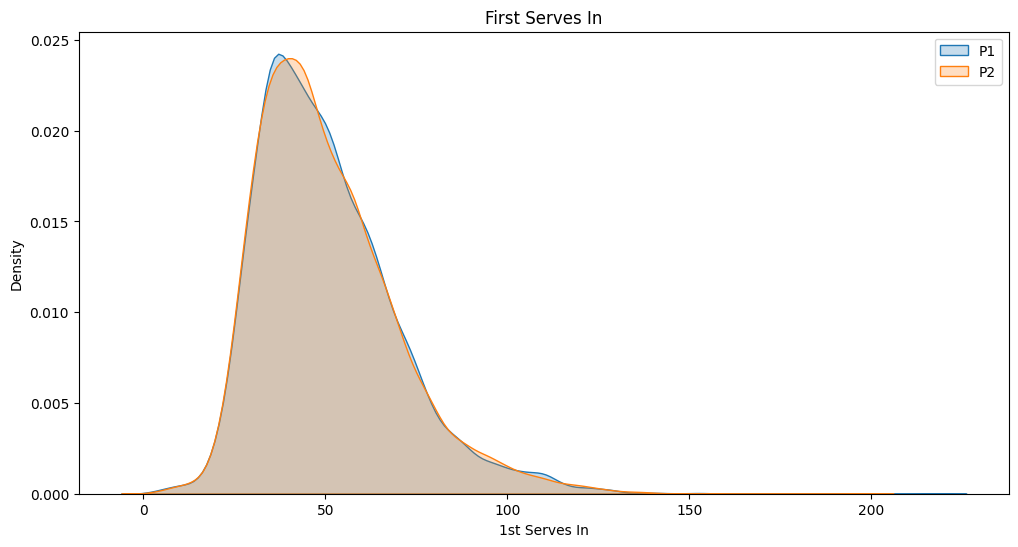

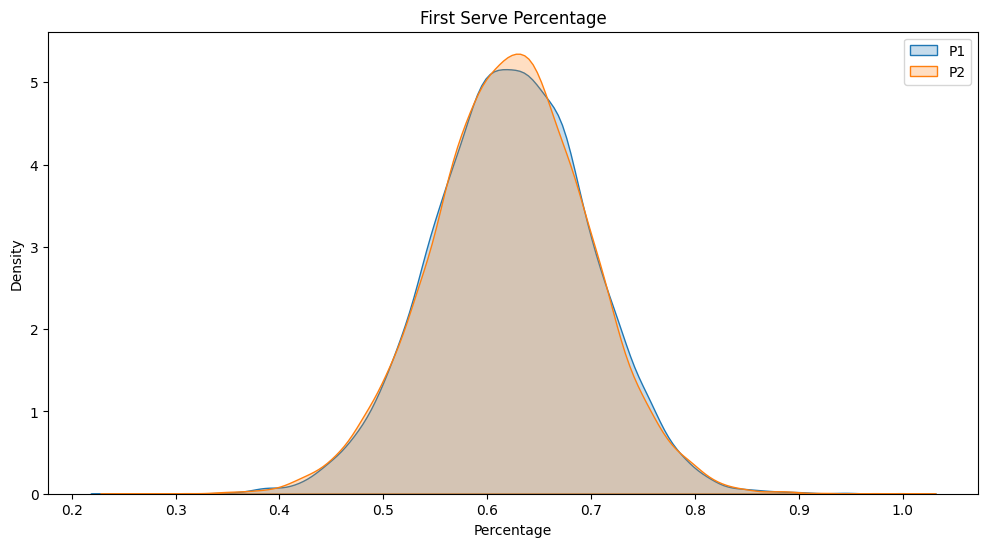

In [13]:
#----------serving stats----------
#plot 5: aces: P1 vs P2
#reveals if either side is consistent or makes more unreturnable (ace) serves
sns.kdeplot(df['p1_ace'], label='P1', fill=True)
sns.kdeplot(df['p2_ace'], label='P2', fill=True)
plt.title("Aces: P1 vs P2")
plt.xlabel("Aces")
plt.legend()
plt.show()

#plot 6:Double Faults: P1 vs P2
#this plot highlights error rates for players
sns.kdeplot(df['p1_df'], label='P1', fill=True)
sns.kdeplot(df['p2_df'], label='P2', fill=True)
plt.title("Double Faults: P1 vs P2")
plt.xlabel("Double Faults")
plt.legend()
plt.show()

#plot 7: Service Points: P1 vs P2
#total serve points per player
sns.histplot(df['p1_svpt'], color="blue", label="P1", kde=True)
sns.histplot(df['p2_svpt'], color="orange", label="P2", kde=True)
plt.title("Service Points")
plt.xlabel("Points")
plt.legend()
plt.show()

#Plot 8: First Serves In: P1 vs P2
#the raw first servce counts
#the higher numbers indicate consistency or even longer matches
sns.kdeplot(df['p1_1stIn'], label='P1', fill=True)
sns.kdeplot(df['p2_1stIn'], label='P2', fill=True)
plt.title("First Serves In")
plt.xlabel("1st Serves In")
plt.legend()
plt.show()

#plot 9: First Serve %: P1 vs P2
#serve reliability
#a higher first serve % generally leads to a better win probability
sns.kdeplot(df['p1_1stIn'] / df['p1_svpt'], label='P1', fill=True)
sns.kdeplot(df['p2_1stIn'] / df['p2_svpt'], label='P2', fill=True)
plt.title("First Serve Percentage")
plt.xlabel("Percentage")
plt.legend()
plt.show()

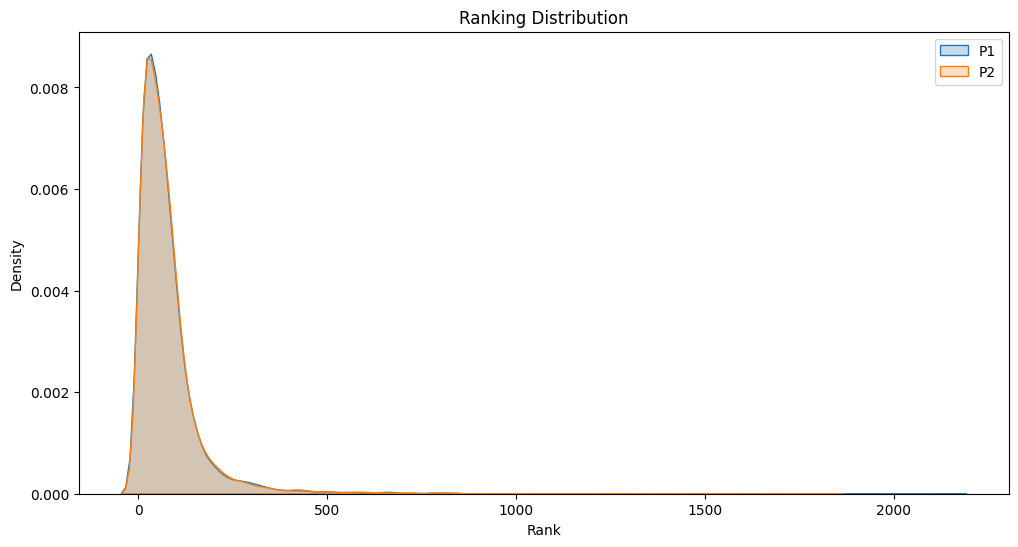

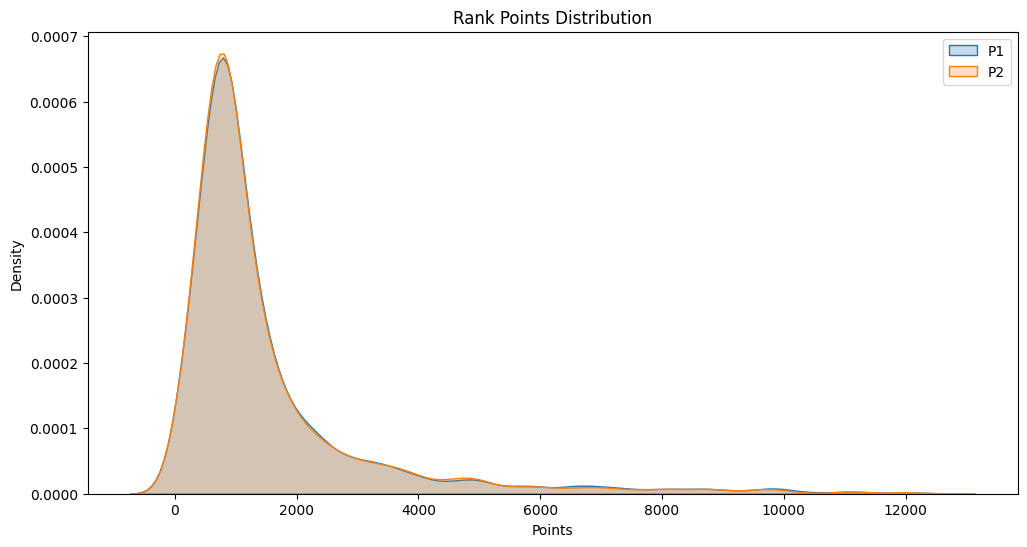

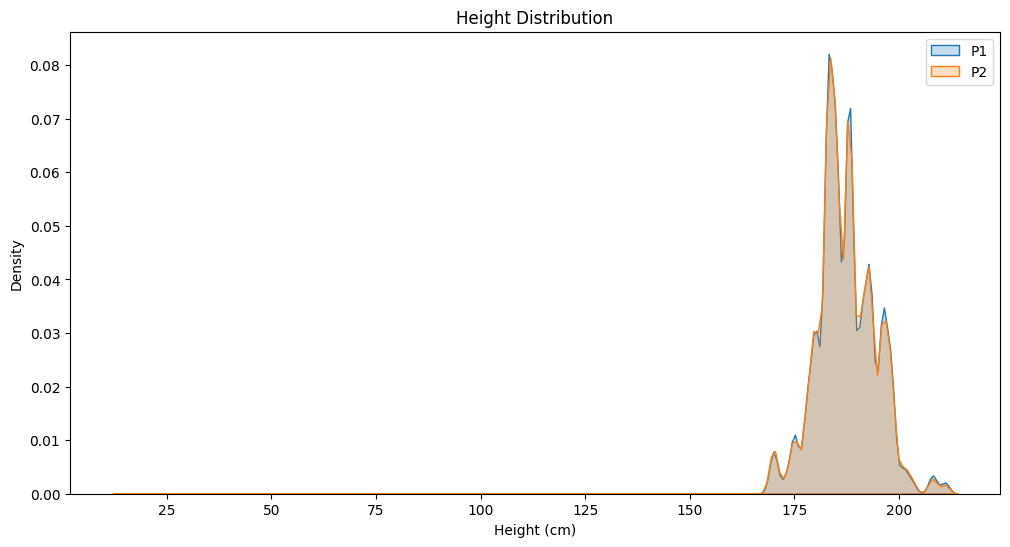

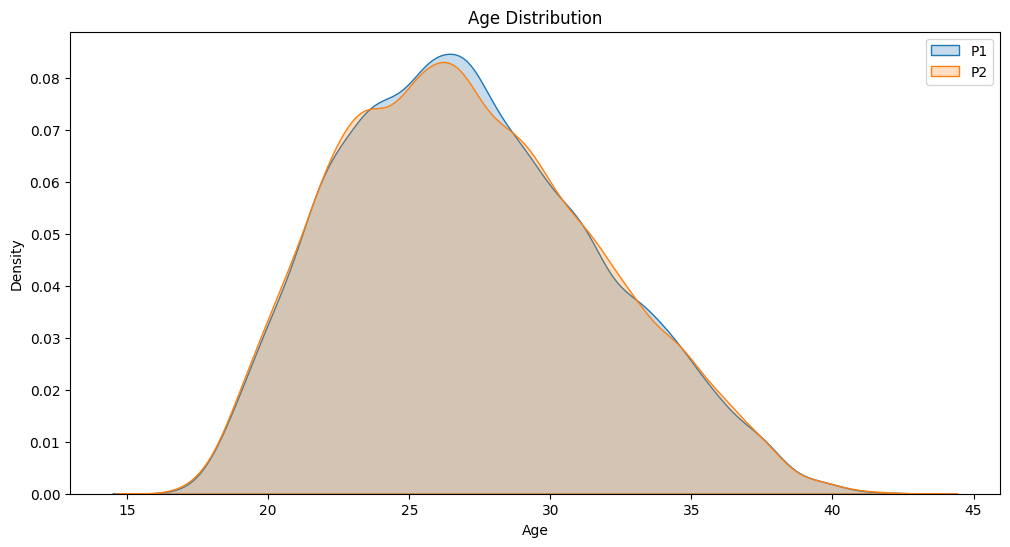

In [14]:
#----------player attributes---------
#plot 10: Ranking: P1 vs P2
#overall player levels
#the concentrated ranges show that most players are in the top 200
sns.kdeplot(df['p1_rank'], label='P1', fill=True)
sns.kdeplot(df['p2_rank'], label='P2', fill=True)
plt.title("Ranking Distribution")
plt.xlabel("Rank")
plt.legend()
plt.show()

#plot 11: Rank Points: P1 vs P2
#shows performance consistency across the season
sns.kdeplot(df['p1_rank_points'], label='P1', fill=True)
sns.kdeplot(df['p2_rank_points'], label='P2', fill=True)
plt.title("Rank Points Distribution")
plt.xlabel("Points")
plt.legend()
plt.show()

#plot 12: Height: P1 vs P2
#does height affect serve, reach, or even court advantage??
sns.kdeplot(df['p1_ht'], label='P1', fill=True)
sns.kdeplot(df['p2_ht'], label='P2', fill=True)
plt.title("Height Distribution")
plt.xlabel("Height (cm)")
plt.legend()
plt.show()

#plot 13: Age: P1 vs P2
#Age. younger players show stamina while the older may show experience
sns.kdeplot(df['p1_age'], label='P1', fill=True)
sns.kdeplot(df['p2_age'], label='P2', fill=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.legend()
plt.show()

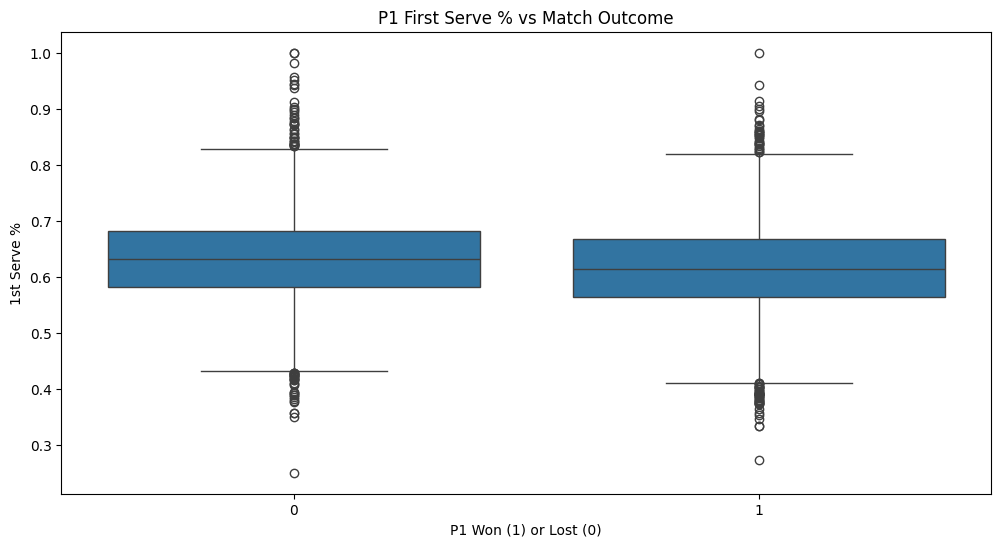

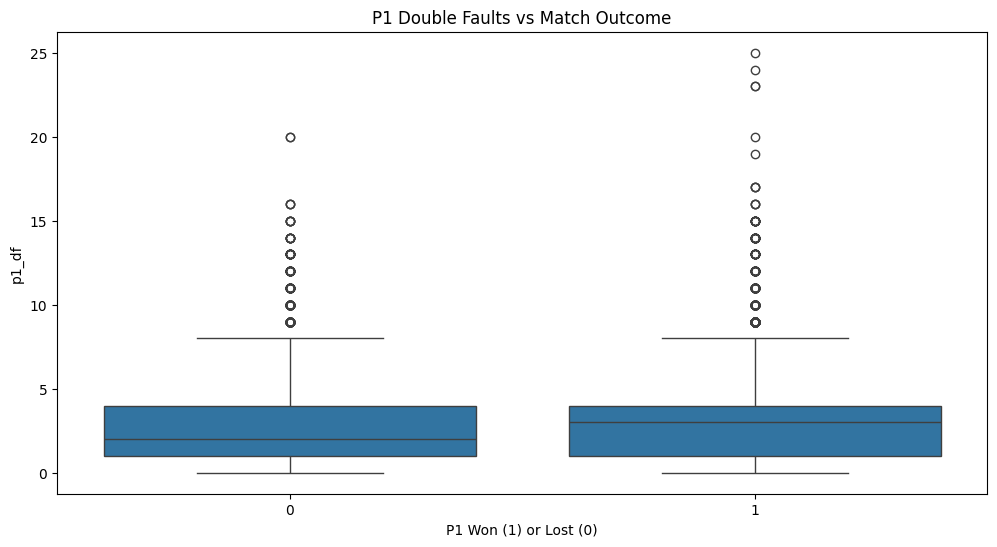

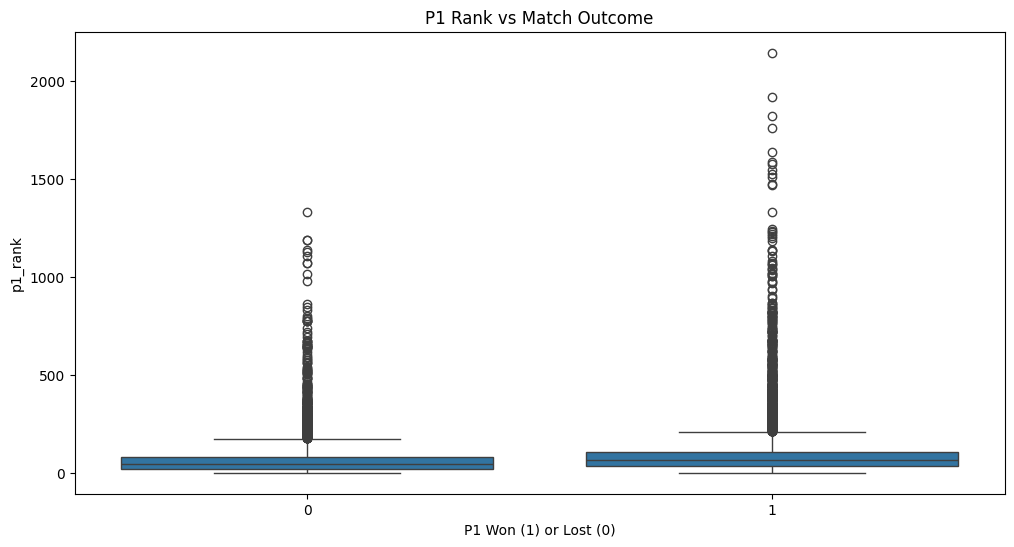

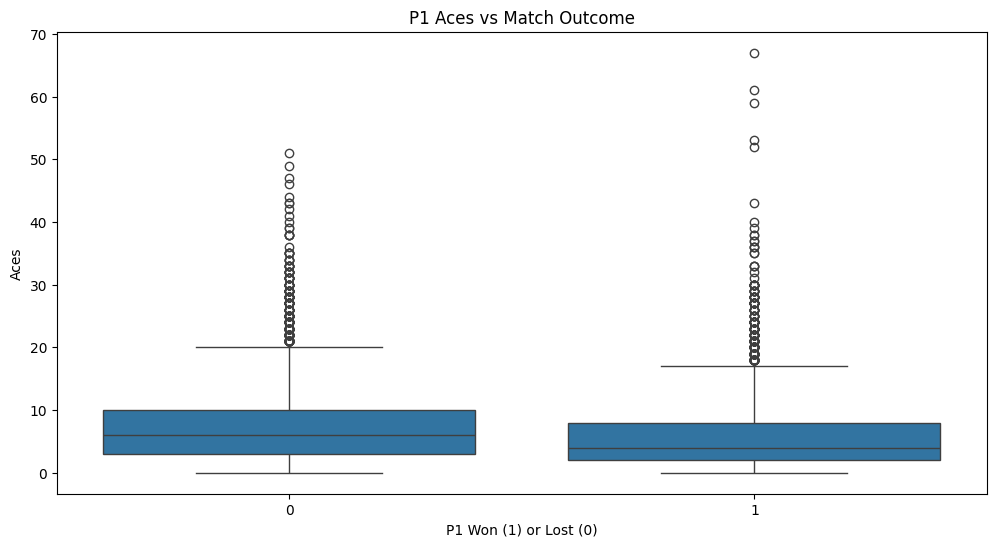

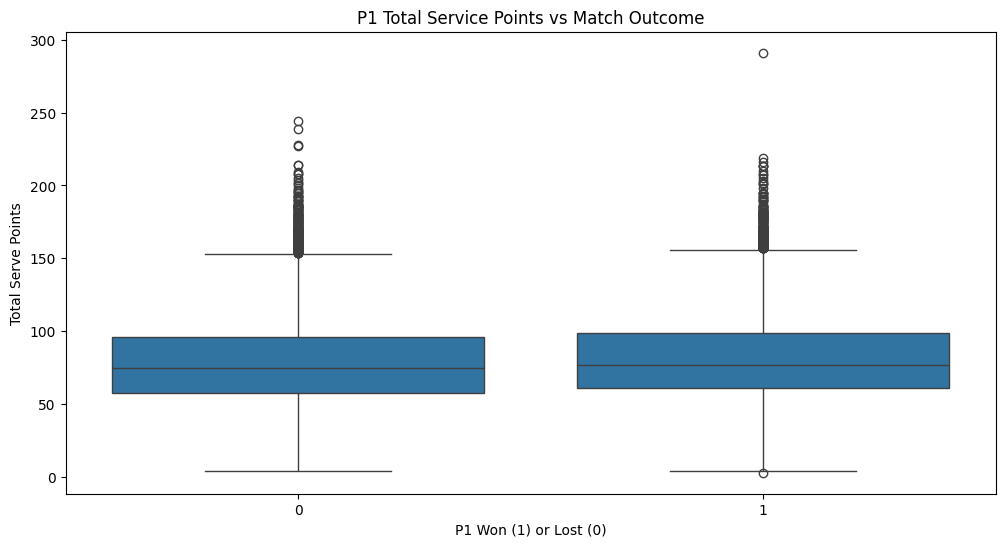

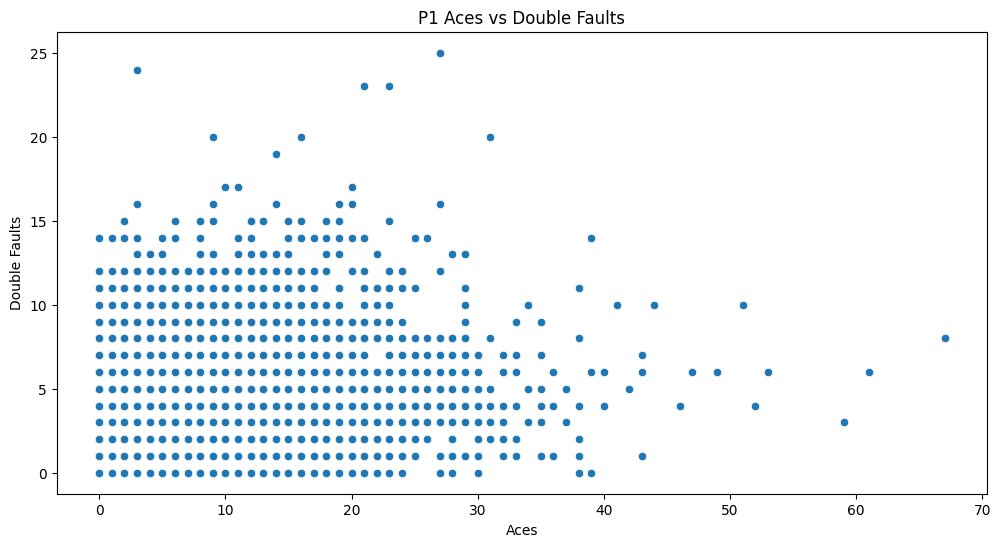

In [15]:
#----------outcomine insights----------
#plot 14: First Serve % vs Win
#a higher first serve % often leads to wins where as a low % can result in more second serve pressure
sns.boxplot(x='winner', y=df['p1_1stIn'] / df['p1_svpt'], data=df)
plt.title("P1 First Serve % vs Match Outcome")
plt.xlabel("P1 Won (1) or Lost (0)")
plt.ylabel("1st Serve %")
plt.show()

#plot 15: Double Faults vs Win
#a higher DF count correlates with losses, ESPECIALLY in close matches
sns.boxplot(x='winner', y='p1_df', data=df)
plt.title("P1 Double Faults vs Match Outcome")
plt.xlabel("P1 Won (1) or Lost (0)")
plt.show()

#plot 16: Rank vs Win
#winners are often in the higher ranks but this shows if there are the UNDERDOGS 
sns.boxplot(x='winner', y='p1_rank', data=df)
plt.title("P1 Rank vs Match Outcome")
plt.xlabel("P1 Won (1) or Lost (0)")
plt.show()

#plot 17: Aces vs Win (P1)
#aces dont GUARANTEE a win but aces are generally corresponded to wins
sns.boxplot(x='winner', y='p1_ace', data=df)
plt.title("P1 Aces vs Match Outcome")
plt.xlabel("P1 Won (1) or Lost (0)")
plt.ylabel("Aces")
plt.show()

#plot 18: Total Service Points vs Win (P1)
#how total points relate to the match outcome
sns.boxplot(x='winner', y='p1_svpt', data=df)
plt.title("P1 Total Service Points vs Match Outcome")
plt.xlabel("P1 Won (1) or Lost (0)")
plt.ylabel("Total Serve Points")
plt.show()

#plot 19: Aces vs Double Faults (P1)
#shows serve styles
#whether they are aggressive (high ace and high df)
#passive (low df, low ace)
sns.scatterplot(x='p1_ace', y='p1_df', data=df)
plt.title("P1 Aces vs Double Faults")
plt.xlabel("Aces")
plt.ylabel("Double Faults")
plt.show()


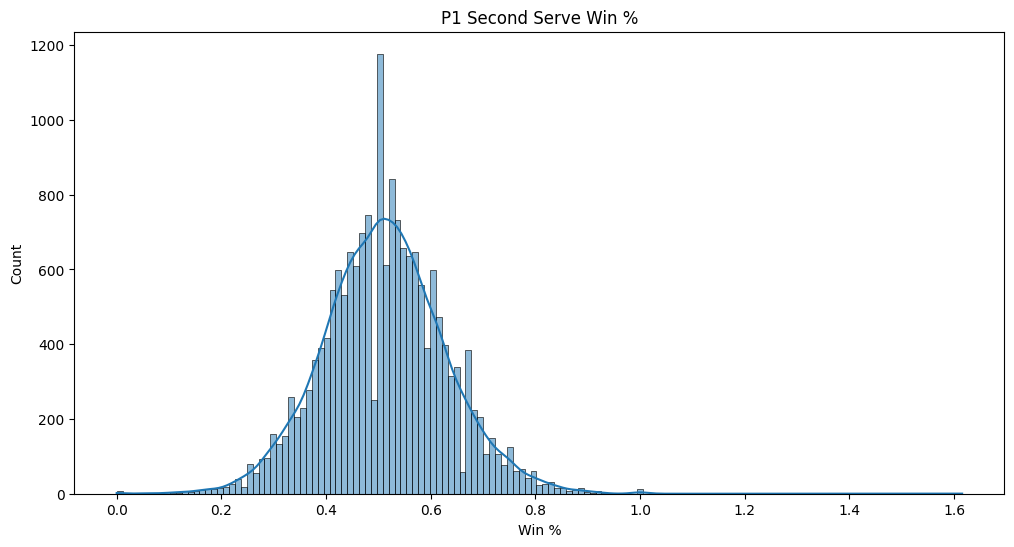

In [16]:
#----------second serve stats----------
#plot 24: Second Serve Win %
df['p1_2ndPct'] = df['p1_2ndWon'] / (df['p1_svpt'] - df['p1_1stIn'])
sns.histplot(df['p1_2ndPct'], kde=True)
plt.title("P1 Second Serve Win %")
plt.xlabel("Win %")
plt.show()

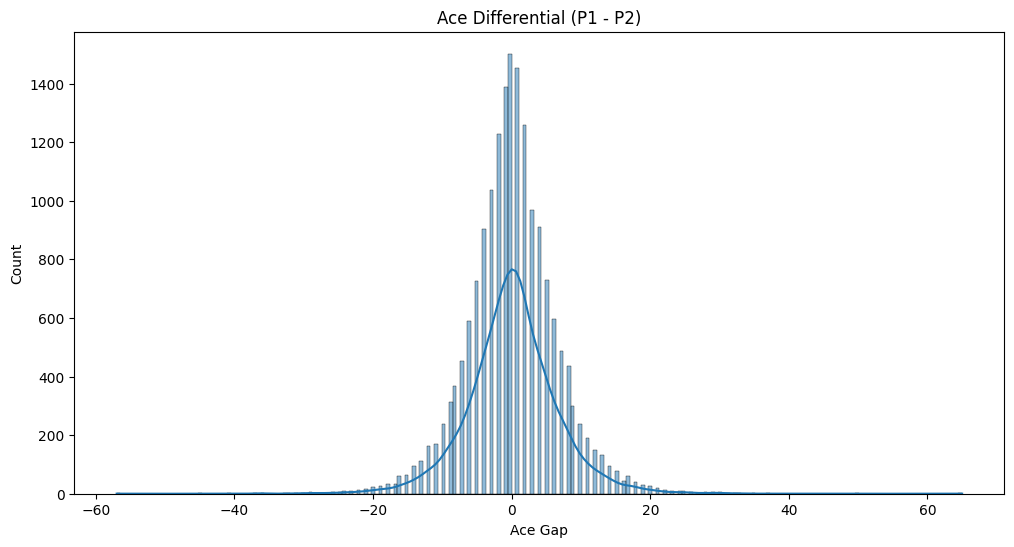

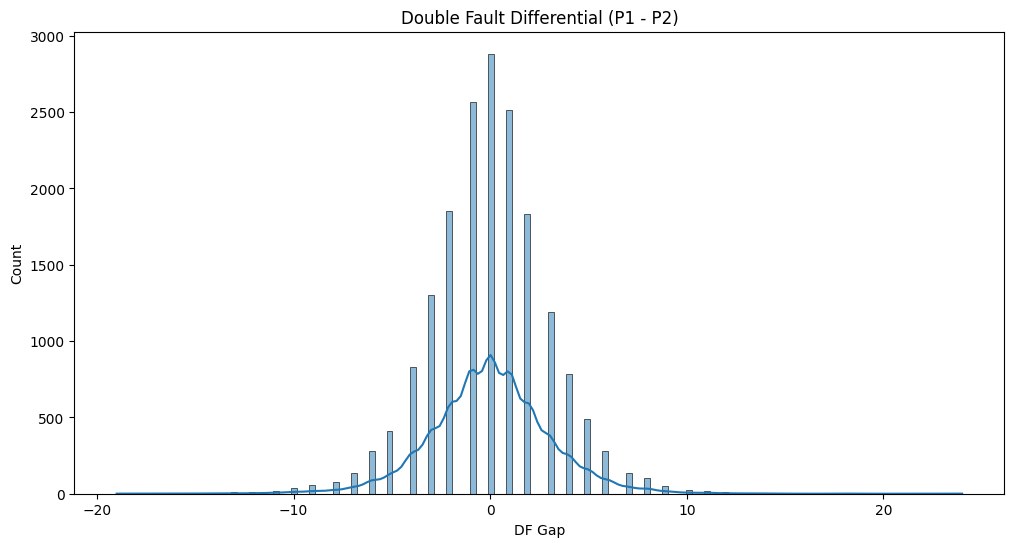

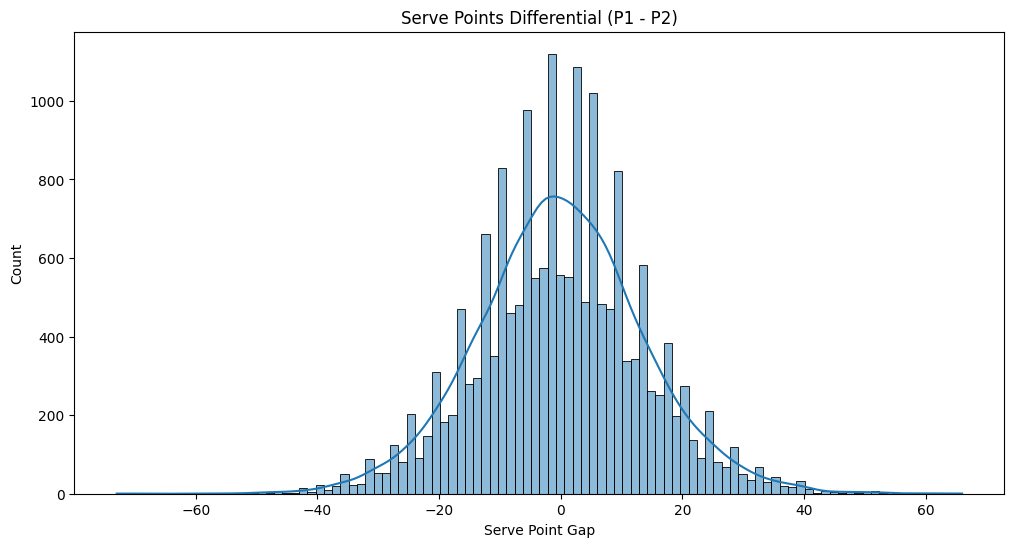

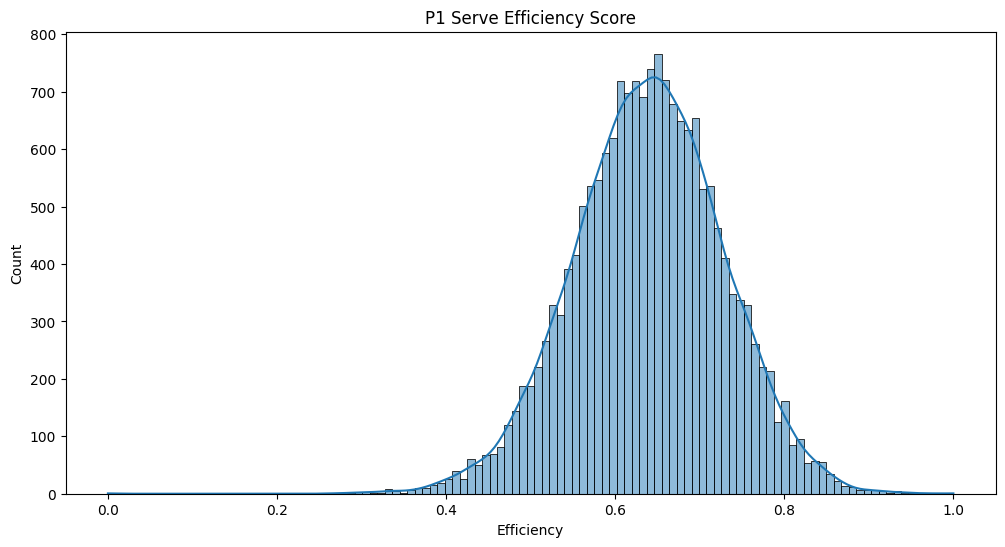

In [17]:
#----------HEAD-TO-HEAD----------
#plot 25: Ace Differential
df['ace_gap'] = df['p1_ace'] - df['p2_ace']
sns.histplot(df['ace_gap'], kde=True)
plt.title("Ace Differential (P1 - P2)")
plt.xlabel("Ace Gap")
plt.show()

#plot 26: Double Fault Differential 
df['df_gap'] = df['p1_df'] - df['p2_df']
sns.histplot(df['df_gap'], kde=True)
plt.title("Double Fault Differential (P1 - P2)")
plt.xlabel("DF Gap")
plt.show()

#plot 27: Serve Points Differential
df['svpt_gap'] = df['p1_svpt'] - df['p2_svpt']
sns.histplot(df['svpt_gap'], kde=True)
plt.title("Serve Points Differential (P1 - P2)")
plt.xlabel("Serve Point Gap")
plt.show()

#plot 28: Serve Efficiency Score (P1)
df['p1_efficiency'] = (df['p1_1stWon'] + df['p1_2ndWon']) / df['p1_svpt']
sns.histplot(df['p1_efficiency'], kde=True)
plt.title("P1 Serve Efficiency Score")
plt.xlabel("Efficiency")
plt.show()

## Reusable functions

In [18]:
# Create a global list to collect model results
model_results = []

def evaluate_model(y_pred_test, y_pred_train, model_name):
    # Calculate test metrics
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test, average='binary')
    recall_test = recall_score(y_test, y_pred_test, average='binary')
    f1_test = f1_score(y_test, y_pred_test, average='binary')

    # Calculate train metrics
    accuracy_train = accuracy_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train, average='binary')
    recall_train = recall_score(y_train, y_pred_train, average='binary')
    f1_train = f1_score(y_train, y_pred_train, average='binary')

    # Print the metrics
    print("=== Test Metrics ===")
    print(f"Accuracy: {accuracy_test}")
    print(f"Precision: {precision_test}")
    print(f"Recall: {recall_test}")
    print(f"F1 Score: {f1_test}")

    print("\n=== Training Metrics ===")
    print(f"Accuracy: {accuracy_train}")
    print(f"Precision: {precision_train}")
    print(f"Recall: {recall_train}")
    print(f"F1 Score: {f1_train}")

    print("\nX_train shape:", X_train.shape)

    # Confusion matrix for test data
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(f'Confusion Matrix (Test Data) - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Add results to the model_results table
    model_results.append({
        "Model": model_name,
        "Train Accuracy": accuracy_train,
        "Train Precision": precision_train,
        "Train Recall": recall_train,
        "Train F1": f1_train,
        "Test Accuracy": accuracy_test,
        "Test Precision": precision_test,
        "Test Recall": recall_test,
        "Test F1": f1_test
    })

In [19]:
from sklearn.feature_selection import RFE

def iterative_feature_elimination(clf, X_train, y_train, X_test, y_test, feature_names=None, target_name='winner'):    
    # Compute baseline F1 score using all features
    baseline_f1 = f1_score(y_test, clf.predict(X_test))
    print(f"Baseline F1: {baseline_f1:.4f}")
    
    # Get the actual number of features from the data
    num_features = X_train.shape[1]
    
    # Handle default feature names
    if feature_names is None:
        try:
            feature_names = X_train.columns.tolist()
        except AttributeError:
            feature_names = [f"f{i}" for i in range(num_features)]
    
    # Ensure feature_names matches the actual data dimension
    if len(feature_names) != num_features:
        feature_names = feature_names[:num_features] if len(feature_names) > num_features else feature_names + [f"f{i}" for i in range(len(feature_names), num_features)]
    
    # Initial setup
    current_X_train = X_train.copy()
    current_X_test = X_test.copy()
    features = feature_names.copy()
    removed_features = []
    
    print(f"Starting with {len(features)} features")
    
    while len(features) > 1:
        # Sanity check to make sure we're not trying to select more features than we have
        n_features_to_select = len(features) - 1
        
        # Check if we have the correct number of features
        actual_features = current_X_train.shape[1]
        if actual_features != len(features):
            print(f"Error: Feature count mismatch. Have {actual_features} features in data but {len(features)} in feature list.")
            print("Synchronizing feature list with data dimensions")
            features = features[:actual_features]
            n_features_to_select = len(features) - 1
        
        print(f"Selecting {n_features_to_select} features from {len(features)} current features")
        
        selector = RFE(estimator=clf, n_features_to_select=n_features_to_select)
        selector.fit(current_X_train, y_train)
        y_pred = selector.predict(current_X_test)
        new_f1 = f1_score(y_test, y_pred)
        
        mask = ~selector.support_
        if not np.any(mask):
            print("No features were dropped. Stopping.")
            break
            
        dropped_idx = np.where(mask)[0][0]
        dropped_feat = features[dropped_idx]
        
        if new_f1 < baseline_f1:
            removed_features.append(dropped_feat)
            print(f"→ Stopping: dropping '{dropped_feat}' drops F1 from {baseline_f1:.4f} to {new_f1:.4f}")
            break
            
        removed_features.append(dropped_feat)
        print(f"Removed '{dropped_feat}' → new F1 = {new_f1:.4f}")
        
        # Update feature list
        features.pop(dropped_idx)
        
        # Update data matrices
        if isinstance(current_X_train, pd.DataFrame):
            current_X_train = current_X_train.iloc[:, selector.support_]
            current_X_test = current_X_test.iloc[:, selector.support_]
        else:
            current_X_train = current_X_train[:, selector.support_]
            current_X_test = current_X_test[:, selector.support_]
    
    print(f"\nTotal removed: {len(removed_features)} features")
    print("Features removed (in order):")
    for feat in removed_features:
        print(f" - {feat}")
    
    return removed_features, features, new_f1

## Neural Network

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

shallow_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(1, activation='sigmoid')  # Binary classification
])

shallow_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

history = shallow_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

shallow_test_loss, shallow_test_acc = shallow_model.evaluate(X_test, y_test, verbose=0)
y_test_pred = (shallow_model.predict(X_test) > 0.5).astype(int).flatten()

shallow_test_precision = precision_score(y_test, y_test_pred)
shallow_test_recall = recall_score(y_test, y_test_pred)
shallow_test_f1 = f1_score(y_test, y_test_pred)

# Evaluate on training data
shallow_train_loss, shallow_train_acc = shallow_model.evaluate(X_train, y_train, verbose=0)
y_train_pred = (shallow_model.predict(X_train) > 0.5).astype(int).flatten()

shallow_train_precision = precision_score(y_train, y_train_pred)
shallow_train_recall = recall_score(y_train, y_train_pred)
shallow_train_f1 = f1_score(y_train, y_train_pred)

print("\n=== Test Performance ===")
print(f'Test Accuracy: {shallow_test_acc:.4f}')
print(f'Precision: {shallow_test_precision:.4f}')
print(f'Recall: {shallow_test_recall:.4f}')
print(f'F1 Score: {shallow_test_f1:.4f}')

print("\n=== Training Performance ===")
print(f'Training Accuracy: {shallow_train_acc:.4f}')
print(f'Precision: {shallow_train_precision:.4f}')
print(f'Recall: {shallow_train_recall:.4f}')
print(f'F1 Score: {shallow_train_f1:.4f}')

model_results.append({
    "Model": "Shallow Neural Network",
    "Train Accuracy": shallow_train_acc,
    "Train Precision": shallow_train_precision,
    "Train Recall": shallow_train_recall,
    "Train F1": shallow_train_f1,
    "Test Accuracy": shallow_test_acc,
    "Test Precision": shallow_test_precision,
    "Test Recall": shallow_test_recall,
    "Test F1": shallow_test_f1
})

C:\Users\mathe\anaconda3\envs\machineLearning\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6954 - loss: 0.5825 - val_accuracy: 0.8343 - val_loss: 0.3956
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8497 - loss: 0.3650 - val_accuracy: 0.9032 - val_loss: 0.2655
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9173 - loss: 0.2349 - val_accuracy: 0.9377 - val_loss: 0.1873
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9410 - loss: 0.1666 - val_accuracy: 0.9398 - val_loss: 0.1583
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9444 - loss: 0.1476 - val_accuracy: 0.9419 - val_loss: 0.1477
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9445 - loss: 0.1409 - val_accuracy: 0.9457 - val_loss: 0.1396
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9502 - loss: 0.1307 - val_accuracy: 0.9457 - val_loss: 0.1375
Epoch 8/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9462 - loss: 0.1332 - val_accuracy: 0.

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Build the deep model
deep_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

deep_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

# Train the model
history = deep_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate on test data
deep_test_loss, deep_test_acc = deep_model.evaluate(X_test, y_test, verbose=0)
y_test_pred = (deep_model.predict(X_test) > 0.5).astype(int).flatten()

deep_test_precision = precision_score(y_test, y_test_pred)
deep_test_recall = recall_score(y_test, y_test_pred)
deep_test_f1 = f1_score(y_test, y_test_pred)

# Evaluate on training data
deep_train_loss, deep_train_acc = deep_model.evaluate(X_train, y_train, verbose=0)
y_train_pred = (deep_model.predict(X_train) > 0.5).astype(int).flatten()

deep_train_precision = precision_score(y_train, y_train_pred)
deep_train_recall = recall_score(y_train, y_train_pred)
deep_train_f1 = f1_score(y_train, y_train_pred)

# Print results
print("\n=== Training Performance ===")
print(f'Training Accuracy: {deep_train_acc:.4f}')
print(f'Precision: {deep_train_precision:.4f}')
print(f'Recall: {deep_train_recall:.4f}')
print(f'F1 Score: {deep_train_f1:.4f}')

print("\n=== Test Performance ===")
print(f'Test Accuracy: {deep_test_acc:.4f}')
print(f'Precision: {deep_test_precision:.4f}')
print(f'Recall: {deep_test_recall:.4f}')
print(f'F1 Score: {deep_test_f1:.4f}')

model_results.append({
    "Model": "Deep Neural Network",
    "Train Accuracy": deep_train_acc,
    "Train Precision": deep_train_precision,
    "Train Recall": deep_train_recall,
    "Train F1": deep_train_f1,
    "Test Accuracy": deep_test_acc,
    "Test Precision": deep_test_precision,
    "Test Recall": deep_test_recall,
    "Test F1": deep_test_f1
})


C:\Users\mathe\anaconda3\envs\machineLearning\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7313 - loss: 0.5085 - val_accuracy: 0.9182 - val_loss: 0.1986
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9337 - loss: 0.1696 - val_accuracy: 0.9335 - val_loss: 0.1600
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9439 - loss: 0.1366 - val_accuracy: 0.9439 - val_loss: 0.1468
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9514 - loss: 0.1222 - val_accuracy: 0.9373 - val_loss: 0.1592
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9508 - loss: 0.1214 - val_accuracy: 0.9450 - val_loss: 0.1465
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9547 - loss: 0.1172 - val_accuracy: 0.9338 - val_loss: 0.1777
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9534 - loss: 0.1168 - val_accuracy: 0.9436 - val_loss: 0.1506
Epoch 8/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9569 - loss: 0.1063 - val_accuracy: 0.

## Logistic Regression

=== Test Metrics ===
Accuracy: 0.9523676880222841
Precision: 0.9515320334261839
Recall: 0.953125
F1 Score: 0.9523278505715083

=== Training Metrics ===
Accuracy: 0.9480356645305099
Precision: 0.9464012251148545
Recall: 0.9495739628439727
F1 Score: 0.9479849393390043

X_train shape: (14356, 23)


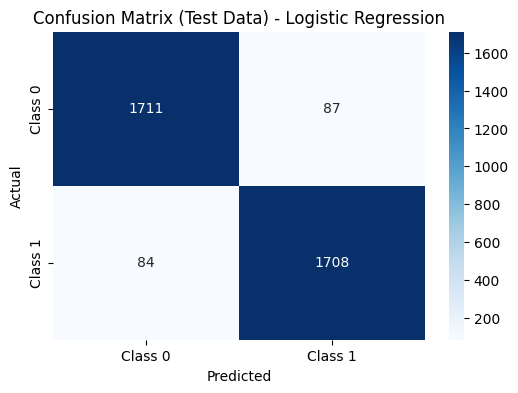

In [22]:
from sklearn.linear_model import LogisticRegression

# Train the model
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

# Predictions for test data
y_pred_test = clf.predict(X_test)

# Predictions for training data
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train,"Logistic Regression")

### Bagging

=== Test Metrics ===
Accuracy: 0.9518105849582172
Precision: 0.9499722067815453
Recall: 0.9536830357142857
F1 Score: 0.9518240044555834

=== Training Metrics ===
Accuracy: 0.9480356645305099
Precision: 0.9461527758452762
Recall: 0.9498533314708758
F1 Score: 0.9479994423532692

X_train shape: (14356, 23)


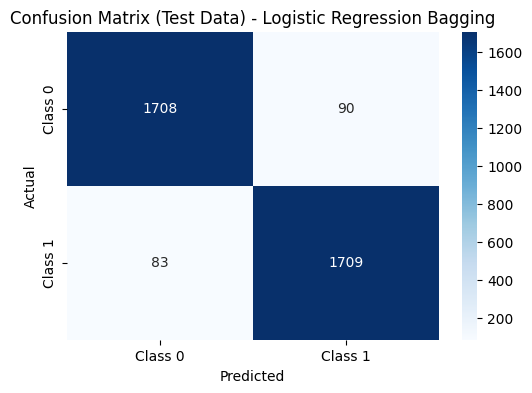

In [23]:
from sklearn.ensemble import BaggingClassifier
# Use logistic model
bagging_clf = BaggingClassifier(estimator=clf, n_estimators=50, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train,"Logistic Regression Bagging")

### Boosting

=== Test Metrics ===
Accuracy: 0.9356545961002786
Precision: 0.9377453729669097
Recall: 0.9330357142857143
F1 Score: 0.9353846153846154

=== Training Metrics ===
Accuracy: 0.9311089439955419
Precision: 0.9295460874408242
Recall: 0.9325324766028775
F1 Score: 0.9310368872463566

X_train shape: (14356, 23)


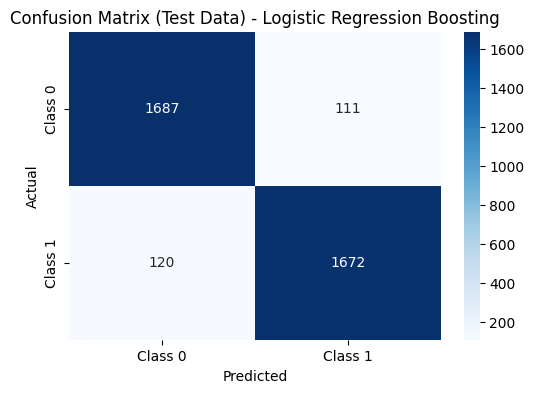

In [24]:
from sklearn.ensemble import AdaBoostClassifier
# Use logistic model 
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=100, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train,"Logistic Regression Boosting")

## Wrapper Method
Running the RFE wrapper method recursively until the percision value begins decreasing from the elimination of Features within the dataset

In [25]:
removed, remaining, final_f1 = iterative_feature_elimination(
    clf=clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=df.drop(columns=['winner']).columns.tolist()
)

Baseline F1: 0.9523
Starting with 23 features
Selecting 22 features from 23 current features
→ Stopping: dropping 'surface' drops F1 from 0.9523 to 0.9518

Total removed: 1 features
Features removed (in order):
 - surface


## Decision Tree

=== Test Metrics ===
Accuracy: 0.6654596100278551
Precision: 0.7510620220900595
Recall: 0.49330357142857145
F1 Score: 0.5954866958571909

=== Training Metrics ===
Accuracy: 0.6760239621064363
Precision: 0.7851296043656207
Recall: 0.4823299343483727
F1 Score: 0.5975599203945661

X_train shape: (14356, 23)


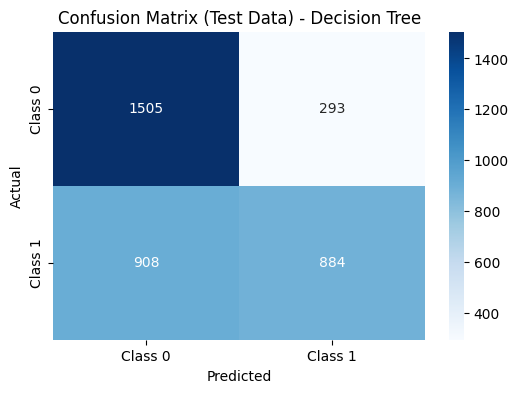

In [26]:
from sklearn.tree import DecisionTreeClassifier

# Train the model
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)
clf.fit(X_train, y_train)

# Predictions for test data
y_pred_test = clf.predict(X_test)

# Predictions for training data
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train,"Decision Tree")

### Bagging

=== Test Metrics ===
Accuracy: 0.7005571030640668
Precision: 0.7147992810065907
Recall: 0.6657366071428571
F1 Score: 0.6893961282866223

=== Training Metrics ===
Accuracy: 0.7236695458344943
Precision: 0.7464484249536751
Recall: 0.6752339712250315
F1 Score: 0.7090575724239091

X_train shape: (14356, 23)


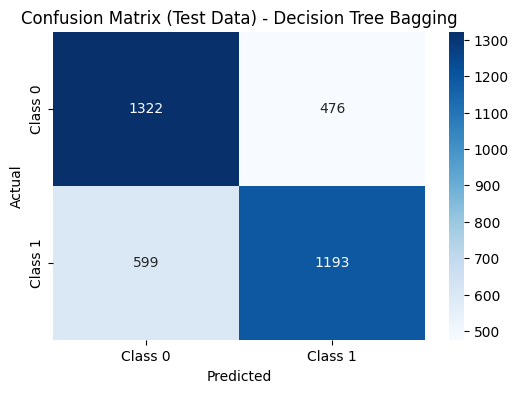

In [27]:
# Use decision tree model
bagging_clf = BaggingClassifier(estimator=clf, n_estimators=50, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train, "Decision Tree Bagging")

### Boosting

=== Test Metrics ===
Accuracy: 0.9242339832869081
Precision: 0.9185022026431718
Recall: 0.9308035714285714
F1 Score: 0.9246119733924612

=== Training Metrics ===
Accuracy: 0.9592504876010031
Precision: 0.9575445434298441
Recall: 0.9608883922335522
F1 Score: 0.959213553649864

X_train shape: (14356, 23)


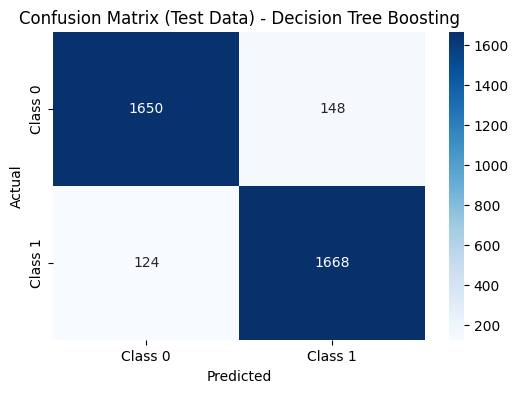

In [28]:
# Use decision tree model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=100, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train, "Decision Tree Boosting")

## Wrapper Methods

In [29]:
removed, remaining, final_f1 = iterative_feature_elimination(
    clf=clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=df.drop(columns=['winner']).columns.tolist()
)

Baseline F1: 0.5955
Starting with 23 features
Selecting 22 features from 23 current features
Removed 'surface' → new F1 = 0.5955
Selecting 21 features from 22 current features
Removed 'p1_hand' → new F1 = 0.5955
Selecting 20 features from 21 current features
Removed 'p1_ht' → new F1 = 0.5955
Selecting 19 features from 20 current features
Removed 'p1_age' → new F1 = 0.5955
Selecting 18 features from 19 current features
Removed 'p2_hand' → new F1 = 0.5955
Selecting 17 features from 18 current features
Removed 'p2_ht' → new F1 = 0.5955
Selecting 16 features from 17 current features
Removed 'p2_age' → new F1 = 0.5955
Selecting 15 features from 16 current features
Removed 'p1_ace' → new F1 = 0.5955
Selecting 14 features from 15 current features
Removed 'p1_df' → new F1 = 0.5955
Selecting 13 features from 14 current features
Removed 'p1_1stIn' → new F1 = 0.5955
Selecting 12 features from 13 current features
Removed 'p2_ace' → new F1 = 0.5955
Selecting 11 features from 12 current features
Rem

## Random Forest

=== Test Metrics ===
Accuracy: 0.7994428969359332
Precision: 0.7967884828349945
Recall: 0.8030133928571429
F1 Score: 0.7998888271261813

=== Training Metrics ===
Accuracy: 0.8865979381443299
Precision: 0.8911045113845284
Recall: 0.8801508590585277
F1 Score: 0.8855938158819395

X_train shape: (14356, 23)


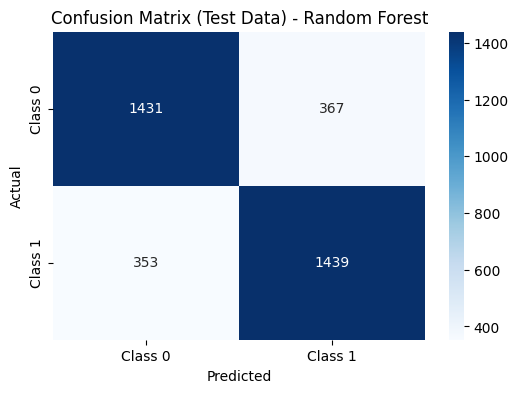

In [30]:
from sklearn.ensemble import RandomForestClassifier

# Train the model
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
clf.fit(X_train, y_train)

# Predictions
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train,"Random Forest")

### Bagging

=== Test Metrics ===
Accuracy: 0.8
Precision: 0.7931222707423581
Recall: 0.8108258928571429
F1 Score: 0.8018763796909493

=== Training Metrics ===
Accuracy: 0.8810950125383115
Precision: 0.8795600111389585
Recall: 0.8823858080737533
F1 Score: 0.8809706436092323

X_train shape: (14356, 23)


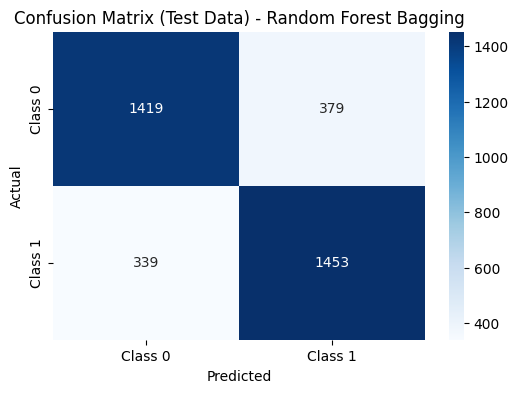

In [31]:
# Use random forest model
bagging_clf = BaggingClassifier(estimator=clf, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train,"Random Forest Bagging")

### Boosting

=== Test Metrics ===
Accuracy: 0.8857938718662952
Precision: 0.8882022471910113
Recall: 0.8822544642857143
F1 Score: 0.8852183650615901

=== Training Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

X_train shape: (14356, 23)


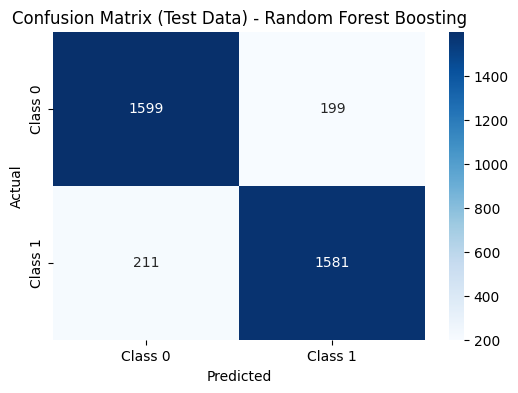

In [32]:
# Use random forest model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=15, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train,"Random Forest Boosting")

## Wrapper Methods

In [33]:
removed, remaining, final_f1 = iterative_feature_elimination(
    clf=clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=df.drop(columns=['winner']).columns.tolist()
)

Baseline F1: 0.7999
Starting with 23 features
Selecting 22 features from 23 current features
→ Stopping: dropping 'p1_hand' drops F1 from 0.7999 to 0.7986

Total removed: 1 features
Features removed (in order):
 - p1_hand


## KNN

=== Test Metrics ===
Accuracy: 0.7559888579387186
Precision: 0.7494553376906318
Recall: 0.7678571428571429
F1 Score: 0.7585446527012127

=== Training Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

X_train shape: (14356, 23)


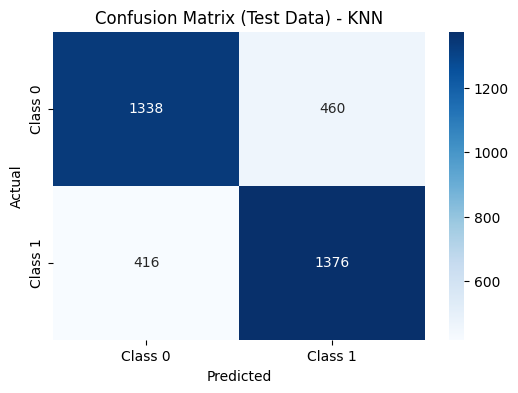

In [34]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize and fit the model
neigh = KNeighborsClassifier(n_neighbors=100, weights='distance', algorithm='auto')
neigh.fit(X_train, y_train)

# Predictions
y_pred_test = neigh.predict(X_test)
y_pred_train = neigh.predict(X_train)

evaluate_model(y_pred_test, y_pred_train,"KNN")

### Bagging

=== Test Metrics ===
Accuracy: 0.8
Precision: 0.7931222707423581
Recall: 0.8108258928571429
F1 Score: 0.8018763796909493

=== Training Metrics ===
Accuracy: 0.8810950125383115
Precision: 0.8795600111389585
Recall: 0.8823858080737533
F1 Score: 0.8809706436092323

X_train shape: (14356, 23)


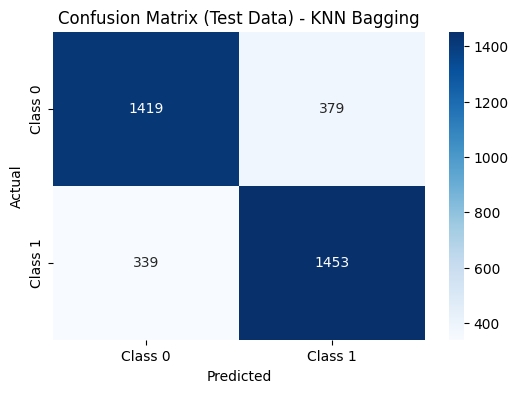

In [35]:
# Use KNN model
bagging_clf = BaggingClassifier(estimator=clf, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train,"KNN Bagging")

### Boosting

=== Test Metrics ===
Accuracy: 0.8857938718662952
Precision: 0.8882022471910113
Recall: 0.8822544642857143
F1 Score: 0.8852183650615901

=== Training Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

X_train shape: (14356, 23)


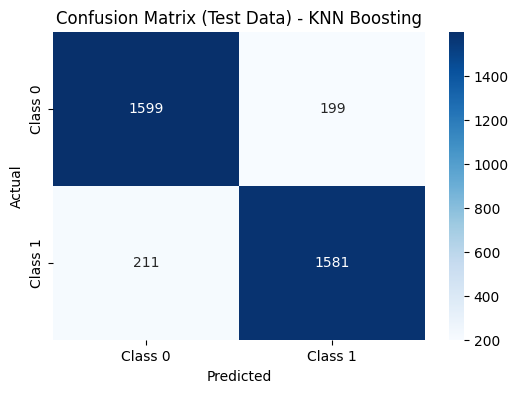

In [36]:
# Use KNN model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=15, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train,"KNN Boosting")

## Wrapper Method

In [37]:
removed, remaining, final_f1 = iterative_feature_elimination(
    clf=clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=df.drop(columns=['winner']).columns.tolist()
)

Baseline F1: 0.7999
Starting with 23 features
Selecting 22 features from 23 current features
→ Stopping: dropping 'p1_hand' drops F1 from 0.7999 to 0.7986

Total removed: 1 features
Features removed (in order):
 - p1_hand


## SVM Linear Kernel

=== Test Metrics ===
Accuracy: 0.9512534818941504
Precision: 0.9499165275459098
Recall: 0.9525669642857143
F1 Score: 0.951239899693508

=== Training Metrics ===
Accuracy: 0.9486625801058791
Precision: 0.9473390916689886
Recall: 0.9498533314708758
F1 Score: 0.9485945455813629

X_train shape: (14356, 23)


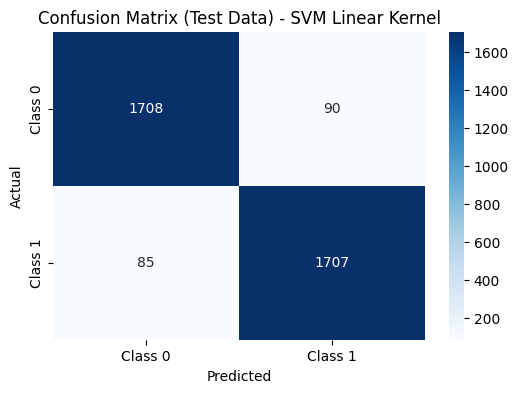

In [38]:
from sklearn.svm import LinearSVC

# Train the model
clf = LinearSVC(random_state=0, tol=1e-5, C=1.0)
clf.fit(X_train, y_train)

# Predictions
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train,"SVM Linear Kernel")

### Bagging

=== Test Metrics ===
Accuracy: 0.9515320334261839
Precision: 0.949944382647386
Recall: 0.953125
F1 Score: 0.9515320334261839

=== Training Metrics ===
Accuracy: 0.9486625801058791
Precision: 0.9469654788418709
Recall: 0.9502723844112306
F1 Score: 0.9486160496409398

X_train shape: (14356, 23)


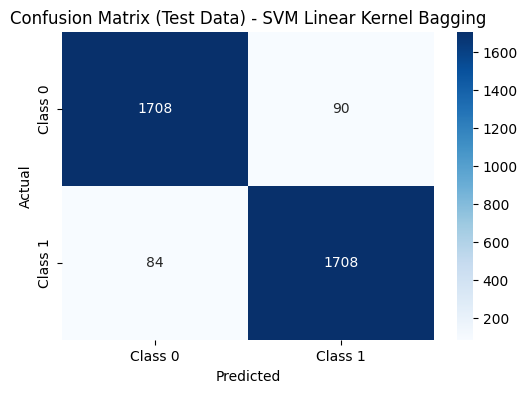

In [39]:
# Use linear SVM model
bagging_clf = BaggingClassifier(estimator=clf, n_estimators=50, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train,"SVM Linear Kernel Bagging")

### Boosting

=== Test Metrics ===
Accuracy: 0.9275766016713092
Precision: 0.9181222707423581
Recall: 0.9386160714285714
F1 Score: 0.9282560706401766

=== Training Metrics ===
Accuracy: 0.9345221510169964
Precision: 0.9267188143268835
Recall: 0.9432881687386506
F1 Score: 0.9349300844524436

X_train shape: (14356, 23)


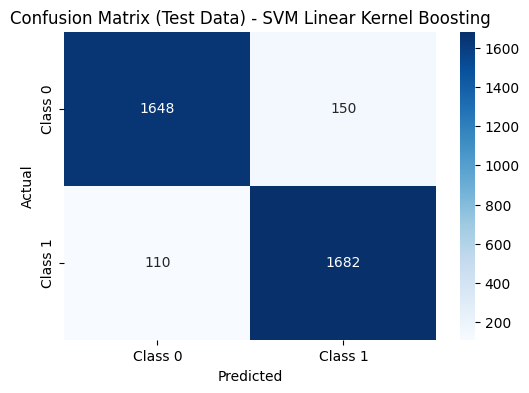

In [40]:
# Use linear SVM model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=100, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train, "SVM Linear Kernel Boosting")

## Wrapper Method

In [41]:
removed, remaining, final_f1 = iterative_feature_elimination(
    clf=clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=df.drop(columns=['winner']).columns.tolist()
)

Baseline F1: 0.9512
Starting with 23 features
Selecting 22 features from 23 current features
Removed 'surface' → new F1 = 0.9515
Selecting 21 features from 22 current features
Removed 'p1_hand' → new F1 = 0.9515
Selecting 20 features from 21 current features
Removed 'p2_ht' → new F1 = 0.9515
Selecting 19 features from 20 current features
Removed 'p1_df' → new F1 = 0.9515
Selecting 18 features from 19 current features
Removed 'p2_age' → new F1 = 0.9518
Selecting 17 features from 18 current features
Removed 'p1_rank' → new F1 = 0.9521
Selecting 16 features from 17 current features
Removed 'p2_rank_points' → new F1 = 0.9521
Selecting 15 features from 16 current features
Removed 'p1_age' → new F1 = 0.9518
Selecting 14 features from 15 current features
Removed 'p1_rank_points' → new F1 = 0.9515
Selecting 13 features from 14 current features
Removed 'p2_rank' → new F1 = 0.9515
Selecting 12 features from 13 current features
Removed 'p2_hand' → new F1 = 0.9524
Selecting 11 features from 12 cur

## SVM Gaussian Kernel

=== Test Metrics ===
Accuracy: 0.9334261838440111
Precision: 0.9350140056022409
Recall: 0.9313616071428571
F1 Score: 0.9331842325971484

=== Training Metrics ===
Accuracy: 0.9568821398718306
Precision: 0.9578549425931112
Recall: 0.9555803883223914
F1 Score: 0.9567163135445074

X_train shape: (14356, 23)


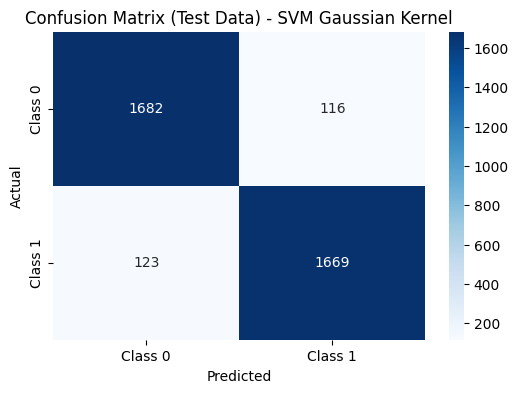

In [42]:
from sklearn.svm import SVC

# Train the model
clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=0)
clf.fit(X_train, y_train)

# Make predictions
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train, "SVM Gaussian Kernel")

### Bagging

=== Test Metrics ===
Accuracy: 0.9317548746518106
Precision: 0.9343065693430657
Recall: 0.9285714285714286
F1 Score: 0.9314301707248811

=== Training Metrics ===
Accuracy: 0.9571607690164391
Precision: 0.9586487244182786
Recall: 0.9553010196954882
F1 Score: 0.9569719443084027

X_train shape: (14356, 23)


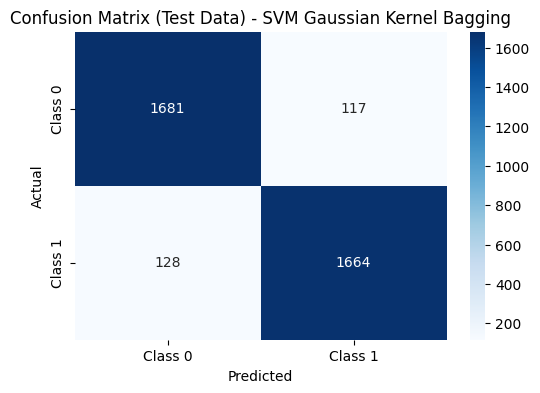

In [43]:
# Use gaussian SVM model
bagging_clf = BaggingClassifier(estimator=clf, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train, "SVM Gaussian Kernel Bagging")

# Note: Boosting results in the model predicting all 1s

## Stacking

### Decision Tree, KNN, & Random Forest -> Logistic

=== Test Metrics ===
Accuracy: 0.8083565459610028
Precision: 0.8042998897464168
Recall: 0.8141741071428571
F1 Score: 0.8092068774265113

=== Training Metrics ===
Accuracy: 0.998397882418501
Precision: 0.9993003078645396
Recall: 0.9974856823578712
F1 Score: 0.9983921705697308

X_train shape: (14356, 23)


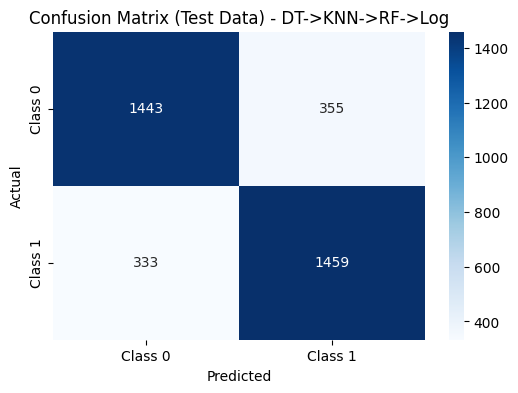

In [44]:
from sklearn.ensemble import StackingClassifier
estimators = [
  ["DecisionTreeClassifier", DecisionTreeClassifier(criterion='entropy', random_state=0)],
  ["KNeighborsClassifier", KNeighborsClassifier(n_neighbors=100, weights='distance')],
  ["RandomForestClassifier", RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)]
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=0))
# Train
stacking_clf.fit(X_train, y_train)
# Predict
y_pred_train = stacking_clf.predict(X_train)
y_pred_test = stacking_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train,"DT->KNN->RF->Log")

### Logistic & KNN -> Decision Tree

=== Test Metrics ===
Accuracy: 0.9272980501392758
Precision: 0.9298147108366086
Recall: 0.9241071428571429
F1 Score: 0.9269521410579346

=== Training Metrics ===
Accuracy: 0.8945388687656729
Precision: 0.9228464419475655
Recall: 0.8604553708618522
F1 Score: 0.8905594911088622

X_train shape: (14356, 23)


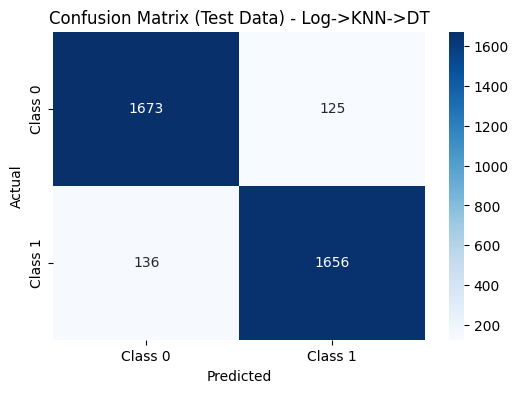

In [45]:
estimators = [
  ["LogisticRegression", LogisticRegression(random_state=0)],
  ["KNeighborsClassifier", KNeighborsClassifier(n_neighbors=100, weights='distance')]
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=DecisionTreeClassifier(random_state=0))
# Train
stacking_clf.fit(X_train, y_train)
# Predict
y_pred_train = stacking_clf.predict(X_train)
y_pred_test = stacking_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train,"Log->KNN->DT")

### Gaussian SVC -> Logistic

=== Test Metrics ===
Accuracy: 0.9328690807799442
Precision: 0.9334823923979877
Recall: 0.9319196428571429
F1 Score: 0.9327003630270874

=== Training Metrics ===
Accuracy: 0.9568124825856784
Precision: 0.9574646704911152
Recall: 0.9558597569492946
F1 Score: 0.9566615406123304

X_train shape: (14356, 23)


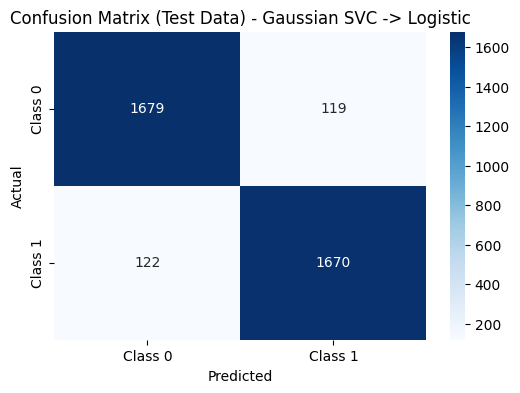

In [46]:
estimators = [
  ["SVC", SVC(kernel='rbf', C=1.0, gamma='scale', random_state=0)],
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=0))
# Train
stacking_clf.fit(X_train, y_train)
# Predict
y_pred_train = stacking_clf.predict(X_train)
y_pred_test = stacking_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train, "Gaussian SVC -> Logistic")

In [47]:
def plot_model_results(results_df):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
    melted_df = pd.melt(
        results_df,
        id_vars=['Model'],
        value_vars=[f'Train {m}' for m in metrics] + [f'Test {m}' for m in metrics],
        var_name='Metric Type',
        value_name='Score'
    )

    # Split Metric Type into two columns: Data Split and Metric
    melted_df[['Split', 'Metric']] = melted_df['Metric Type'].str.extract(r'(Train|Test)\s+(.*)')

    # Plot
    g = sns.catplot(
        data=melted_df,
        kind='bar',
        x='Model',
        y='Score',
        hue='Split',
        col='Metric',
        col_wrap=2,
        height=4,
        aspect=1.2,
        palette='Set2',
        sharey=False
    )
    g.set_titles("{col_name}")
    g.set_axis_labels("Model", "Score")
    g.set_xticklabels(rotation=45)
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle("Training vs Test Metrics by Model")
    plt.show()

In [ ]:
plot_model_results(pd.DataFrame(model_results))

## DecisionTreeClassifier with Hypertuning

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_manual = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42
)
dt_manual.fit(X_train, y_train)

y_pred_test  = dt_manual.predict(X_test)
y_pred_train = dt_manual.predict(X_train)

evaluate_model(y_pred_test, y_pred_train,"Decision Tree Regularization")

## Logistic Regression With Hypertuning

In [ ]:
# Tried on this one but not much change, running gridsearch on all will blow up our computers

# testing elastic 
from sklearn.linear_model import LogisticRegression

log_manual = LogisticRegression(
    penalty="elasticnet",
    C=1.0,
    l1_ratio=0.5,
    class_weight="balanced",
    solver="saga",
    max_iter=10000,
    random_state=42
)
log_manual.fit(X_train, y_train)

y_pred_test  = log_manual.predict(X_test)
y_pred_train = log_manual.predict(X_train)

evaluate_model(y_pred_test, y_pred_train,"Logistic Regression Regularization")

In [ ]:
pd.DataFrame(model_results)